In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
import os

In [2]:
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Load data
data_path = 'C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-processed.csv'
data = pd.read_csv(data_path, sep=',')
print(data.shape)

# Separate features and target
X = data.drop(columns=['y'])
y = data['y']

# Define numeric columns
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Scale numeric columns
scale = MinMaxScaler()
X[numeric_cols] = scale.fit_transform(X[numeric_cols])

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


(45211, 33)


In [4]:
# Apply SMOTEENN for class balancing
smoteenn = SMOTEENN(random_state=42)
X_resample, y_resample = smoteenn.fit_resample(X_train, y_train)
X_resample = pd.DataFrame(X_resample, columns=X.columns)
y_resample = pd.Series(y_resample)


In [5]:
# Feature selection with BorutaPy
rf = xgb.XGBClassifier(eval_metric='logloss')
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
feat_selector.fit(X_resample.values, y_resample.values.ravel())
X_filtered = X.columns[feat_selector.support_].tolist()
print(f"Selected features: {len(X_filtered)}")


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Selected features: 26


In [ ]:
# Filter data with selected features
X_train_filtered = X_resample[X_filtered].values
X_test_filtered = X_test[X_filtered].values
y_train_filtered = y_resample.values
y_test_filtered = y_test.values

# Neural network parameters
input_size = len(X_filtered)
hidden_units = 64
hidden_layers = 2
dropout_rate = 0.2
learning_rate = 0.0001
epochs = 50
n_iterations = 10
l2_norm_clip = 1.0

# Define parameter values to test
batch_size_values = [16, 32, 64, 128]
sample_size_ratio_values = [1, 0.5, 0.1, 0.05]
target_eps_values = [0.5, 1.0, 2.0]  # Target epsilon values for better control

# Fixed default values
default_batch_size = 32


In [7]:
# Function to compute privacy budget and adjust noise_multiplier
def adjust_noise_multiplier(n, batch_size, epochs, target_eps, delta=1e-5, max_iterations=100):
    low, high = 0.1, 10.0  # Initial range for noise_multiplier
    for _ in range(max_iterations):
        noise_multiplier = (low + high) / 2
        eps = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
            n=n, batch_size=batch_size, noise_multiplier=noise_multiplier,
            epochs=epochs, delta=delta
        )[0]
        if abs(eps - target_eps) < 0.01:  # Convergence criterion
            return noise_multiplier, eps
        elif eps > target_eps:
            low = noise_multiplier
        else:
            high = noise_multiplier
    return noise_multiplier, eps  # Return best approximation if not converged

# Define neural network model
def create_model(input_size, hidden_units, hidden_layers, dropout_rate, use_dp=False,
                 num_microbatches=None, l2_norm_clip=l2_norm_clip, noise_multiplier=1.1):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(input_size,)))
    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    if use_dp:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate
        )
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to train model
def train_model(X_train, y_train, X_test, y_test, batch_size, epochs, use_dp=False,
                num_microbatches=None, l2_norm_clip=l2_norm_clip, noise_multiplier=1.1):
    model = create_model(input_size, hidden_units, hidden_layers, dropout_rate, use_dp=use_dp,
                         num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
                         noise_multiplier=noise_multiplier)
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test)
    )
    
    y_pred_prob_test = model.predict(X_test, batch_size=batch_size).flatten()
    y_pred_test = (y_pred_prob_test > 0.4).astype(int)
    
    return y_pred_prob_test, y_pred_test

# Function to evaluate model
def evaluate_model(y_true, y_pred, y_pred_prob):
    conf_matrix = confusion_matrix(y_true, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_rate = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_rate = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_true, y_pred_prob),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Type I Error': false_positive_rate,
        'Type II Error': false_negative_rate
    }

# Function to run multiple iterations
def run_iterations(X_train, y_train, X_test, y_test, batch_size, epochs, use_dp, n_iterations,
                   num_microbatches, l2_norm_clip, noise_multiplier):
    results = []
    for _ in range(n_iterations):
        y_pred_prob_test, y_pred_test = train_model(
            X_train, y_train, X_test, y_test, batch_size, epochs, use_dp=use_dp,
            num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier
        )
        result = evaluate_model(y_test, y_pred_test, y_pred_prob_test)
        results.append(result)
    return pd.DataFrame(results)

# Function to compute statistics
def compute_statistics(df):
    stats = {
        'mean': df.mean(),
        'min': df.min(),
        'max': df.max()
    }
    return stats

# Function to subsample training data
def subsample_data(X, y, sample_size_ratio, random_state=42):
    if sample_size_ratio >= 1.0:
        return X, y
    n_samples = int(len(X) * sample_size_ratio)
    idx = np.random.choice(len(X), n_samples, replace=False)
    return X[idx], y[idx]


In [8]:
# Train model without DP
print("Training model without DP...")
results_no_dp = run_iterations(
    X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered,
    batch_size=default_batch_size, epochs=epochs, use_dp=False, n_iterations=n_iterations,
    num_microbatches=None, l2_norm_clip=None, noise_multiplier=None
)
results_no_dp_stats = compute_statistics(results_no_dp)


Training model without DP...
Epoch 1/50
1672/1672 [==============================] - 1s 893us/step - loss: 0.5825 - accuracy: 0.6829 - val_loss: 0.6078 - val_accuracy: 0.6684
Epoch 2/50
1672/1672 [==============================] - 1s 745us/step - loss: 0.4519 - accuracy: 0.7876 - val_loss: 0.5303 - val_accuracy: 0.7481
Epoch 3/50
1672/1672 [==============================] - 2s 929us/step - loss: 0.3729 - accuracy: 0.8428 - val_loss: 0.5640 - val_accuracy: 0.7496
Epoch 4/50
1672/1672 [==============================] - 2s 992us/step - loss: 0.3168 - accuracy: 0.8757 - val_loss: 0.5102 - val_accuracy: 0.8047
Epoch 5/50
1672/1672 [==============================] - 1s 790us/step - loss: 0.2889 - accuracy: 0.8883 - val_loss: 0.4939 - val_accuracy: 0.8159
Epoch 6/50
1672/1672 [==============================] - 1s 709us/step - loss: 0.2743 - accuracy: 0.8948 - val_loss: 0.4694 - val_accuracy: 0.8274
Epoch 7/50
1672/1672 [==============================] - 1s 626us/step - loss: 0.2662 - accuracy

In [9]:
# Run experiments targeting specific epsilon values
delta = 1e-5

# 1. Vary batch_size with target epsilon
results_batch_size = {}
eps_batch_size = {}
noise_batch_size = {}
for bs in batch_size_values:
    for target_eps in target_eps_values:
        print(f"\nTraining model with batch_size={bs}, target_eps={target_eps}...")
        n = len(X_train_filtered)
        num_microbatches = min(bs // 4, bs)  # Ensure num_microbatches is reasonable
        noise_multiplier, eps = adjust_noise_multiplier(n, bs, epochs, target_eps, delta)
        results = run_iterations(
            X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered,
            batch_size=bs, epochs=epochs, use_dp=True, n_iterations=n_iterations,
            num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier
        )
        key = (bs, target_eps)
        results_batch_size[key] = compute_statistics(results)
        eps_batch_size[key] = eps
        noise_batch_size[key] = noise_multiplier



Training model with batch_size=16, target_eps=0.5...
DP-SGD with sampling rate = 0.0299% and noise_multiplier = 5.05 iterated over 167200 steps satisfies differential privacy with eps = 0.122 and delta = 1e-05.
The optimal RDP order is 256.0.
DP-SGD with sampling rate = 0.0299% and noise_multiplier = 2.5749999999999997 iterated over 167200 steps satisfies differential privacy with eps = 0.263 and delta = 1e-05.
The optimal RDP order is 63.0.
DP-SGD with sampling rate = 0.0299% and noise_multiplier = 1.3375 iterated over 167200 steps satisfies differential privacy with eps = 0.585 and delta = 1e-05.
The optimal RDP order is 28.0.
DP-SGD with sampling rate = 0.0299% and noise_multiplier = 1.9562499999999998 iterated over 167200 steps satisfies differential privacy with eps = 0.329 and delta = 1e-05.
The optimal RDP order is 61.0.
DP-SGD with sampling rate = 0.0299% and noise_multiplier = 1.6468749999999999 iterated over 167200 steps satisfies differential privacy with eps = 0.419 and de

In [10]:
# 2. Vary sample_size_ratio with target epsilon
results_sample_size = {}
eps_sample_size = {}
noise_sample_size = {}
for ssr in sample_size_ratio_values:
    for target_eps in target_eps_values:
        print(f"\nTraining model with sample_size_ratio={ssr}, target_eps={target_eps}...")
        X_sub, y_sub = subsample_data(X_train_filtered, y_train_filtered, ssr)
        n = len(X_sub)
        num_microbatches = min(default_batch_size // 4, default_batch_size)
        noise_multiplier, eps = adjust_noise_multiplier(n, default_batch_size, epochs, target_eps, delta)
        results = run_iterations(
            X_sub, y_sub, X_test_filtered, y_test_filtered,
            batch_size=default_batch_size, epochs=epochs, use_dp=True, n_iterations=n_iterations,
            num_microbatches=num_microbatches, l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier
        )
        key = (ssr, target_eps)
        results_sample_size[key] = compute_statistics(results)
        eps_sample_size[key] = eps
        noise_sample_size[key] = noise_multiplier



Training model with sample_size_ratio=1, target_eps=0.5...
DP-SGD with sampling rate = 0.0598% and noise_multiplier = 5.05 iterated over 83600 steps satisfies differential privacy with eps = 0.167 and delta = 1e-05.
The optimal RDP order is 128.0.
DP-SGD with sampling rate = 0.0598% and noise_multiplier = 2.5749999999999997 iterated over 83600 steps satisfies differential privacy with eps = 0.34 and delta = 1e-05.
The optimal RDP order is 63.0.
DP-SGD with sampling rate = 0.0598% and noise_multiplier = 1.3375 iterated over 83600 steps satisfies differential privacy with eps = 0.763 and delta = 1e-05.
The optimal RDP order is 25.0.
DP-SGD with sampling rate = 0.0598% and noise_multiplier = 1.9562499999999998 iterated over 83600 steps satisfies differential privacy with eps = 0.46 and delta = 1e-05.
The optimal RDP order is 51.0.
DP-SGD with sampling rate = 0.0598% and noise_multiplier = 1.6468749999999999 iterated over 83600 steps satisfies differential privacy with eps = 0.566 and del

In [11]:

# Save results to CSV
results_stats = {
    'batch_size': results_batch_size,
    'sample_size_ratio': results_sample_size
}
data = {}

# Add results for non-DP model
data['No DP (mean)'] = results_no_dp_stats['mean']
data['No DP (min)'] = results_no_dp_stats['min']
data['No DP (max)'] = results_no_dp_stats['max']

# Add results for DP models
for param, stats_dict in results_stats.items():
    for (value, target_eps), stats in stats_dict.items():
        eps = eps_batch_size.get((value, target_eps), float('inf')) if param == 'batch_size' else eps_sample_size.get((value, target_eps), float('inf'))
        noise = noise_batch_size.get((value, target_eps), 0) if param == 'batch_size' else noise_sample_size.get((value, target_eps), 0)
        model = f'{param}={value} (ε={eps:.2f}, noise={noise:.2f})'
        data[f'{model} (mean)'] = stats['mean']
        data[f'{model} (min)'] = stats['min']
        data[f'{model} (max)'] = stats['max']

# Create DataFrame and save to CSV
results_df = pd.DataFrame(data).round(4)
results_df.to_csv('results/CDP_adjusted_results.csv')
print("\nResults saved to 'results/CDP_adjusted_results.csv'")
print("\nResults (Averages):\n", results_df[[col for col in results_df.columns if 'mean' in col]])



Results saved to 'results/CDP_adjusted_results.csv'

Results (Averages):
                No DP (mean)  batch_size=16 (ε=0.50, noise=1.47) (mean)  \
ROC AUC              0.9004                                     0.7573   
Accuracy             0.8067                                     0.5518   
Precision            0.3622                                     0.1824   
Recall               0.8525                                     0.8127   
F1 Score             0.5081                                     0.2979   
Type I Error         0.1994                                     0.4828   
Type II Error        0.1475                                     0.1873   

               batch_size=16 (ε=0.99, noise=1.01) (mean)  \
ROC AUC                                           0.7559   
Accuracy                                          0.5414   
Precision                                         0.1797   
Recall                                            0.8181   
F1 Score                        

In [12]:

# Function to plot results, including No DP model
def plot_parameter_results(stats_dict, eps_dict, noise_dict, param_name, colors, no_dp_stats):
    metrics = list(no_dp_stats['mean'].keys())
    values = sorted(set(val for val, _ in stats_dict.keys()))
    eps_values = sorted(set(eps for _, eps in stats_dict.keys()))
    n_metrics = len(metrics)
    
    plt.figure(figsize=(12, 6))
    x_positions = np.arange(n_metrics)
    
    # Plot No DP model
    means = [no_dp_stats['mean'][metric] for metric in metrics]
    mins = [no_dp_stats['min'][metric] for metric in metrics]
    maxs = [no_dp_stats['max'][metric] for metric in metrics]
    plt.scatter(x_positions, means, color=colors[0], label='No DP', s=100)
    for metric_idx in range(n_metrics):
        plt.vlines(x_positions[metric_idx], mins[metric_idx], maxs[metric_idx], color=colors[0], linestyle='-', linewidth=1)
    
    # Plot results for each combination
    color_idx = 1
    for value in values:
        for target_eps in eps_values:
            key = (value, target_eps)
            if key in stats_dict:
                means = [stats_dict[key]['mean'][metric] for metric in metrics]
                mins = [stats_dict[key]['min'][metric] for metric in metrics]
                maxs = [stats_dict[key]['max'][metric] for metric in metrics]
                noise = noise_dict[key]
                plt.scatter(x_positions + (color_idx - len(values) * len(eps_values) / 2) * 0.1, means, 
                            color=colors[color_idx % len(colors)], 
                            label=f'{param_name}={value} (ε={eps_dict[key]:.2f}, noise={noise:.2f})', s=100)
                for metric_idx in range(n_metrics):
                    plt.vlines(x_positions[metric_idx] + (color_idx - len(values) * len(eps_values) / 2) * 0.1, 
                               mins[metric_idx], maxs[metric_idx], 
                               color=colors[color_idx % len(colors)], linestyle='-', linewidth=1)
                color_idx += 1
    
    plt.xticks(x_positions, metrics, rotation=45)
    plt.title(f'Effect of Varying {param_name} on Model Performance')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.legend(title=f'{param_name} Configurations', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'figures/Effect_of_{param_name}_adjusted.jpg', dpi=300, bbox_inches='tight')
    plt.show()


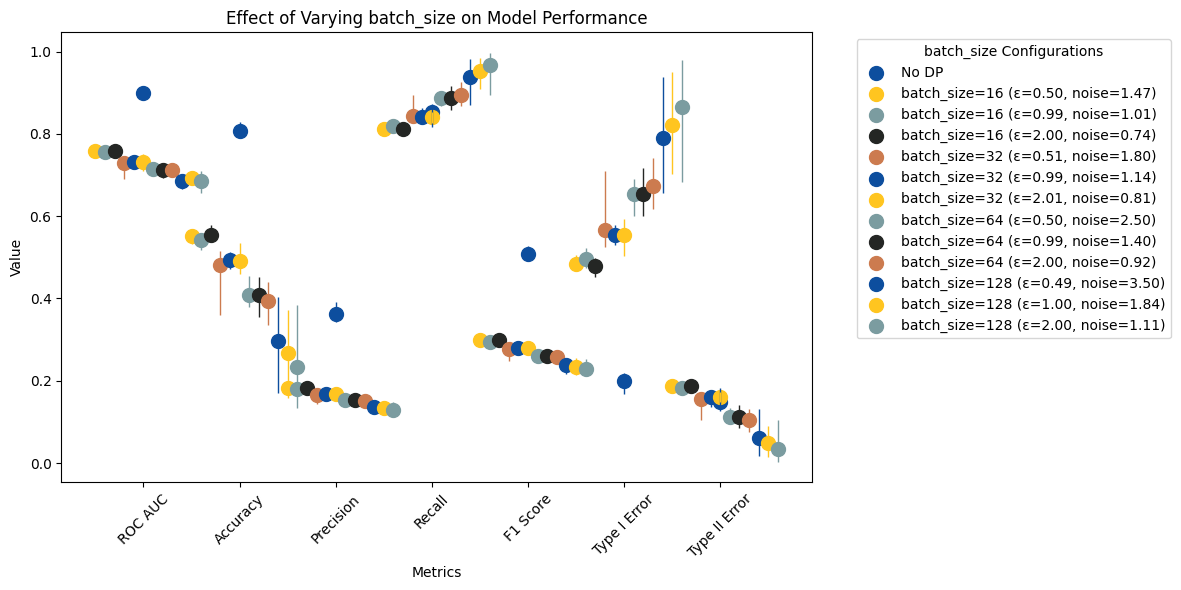

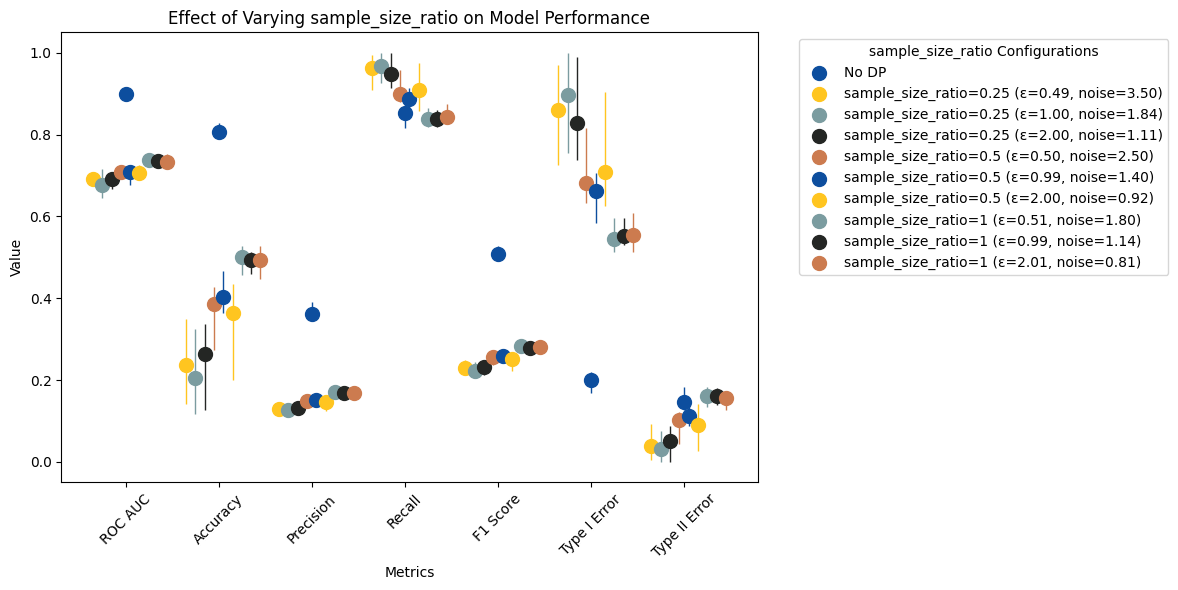

In [13]:

# Define colors
colors = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624', '#cc7b4f']

# Plot results
plot_parameter_results(results_batch_size, eps_batch_size, noise_batch_size, 'batch_size', colors, results_no_dp_stats)
plot_parameter_results(results_sample_size, eps_sample_size, noise_sample_size, 'sample_size_ratio', colors, results_no_dp_stats)